In [1]:
%load_ext rpy2.ipython


In [2]:
%%R 
library(rethinking)

Loading required package: rstan
Loading required package: StanHeaders

rstan version 2.26.16 (Stan version 2.26.1)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

Loading required package: cmdstanr
This is cmdstanr version 0.5.3
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
Loading required package: parallel
rethinking (Version 2.31)

Attaching package: ‘rethinking’

The following object is masked from ‘package:rstan’:

    stan

The following object is masked from ‘package:stats’:

    rstudent



# Quick Order of Magnitude

Even though the full expansion is long, 
$$
P(v|pos) =\frac{P(pos|v) P(v)}{ P(pos) } 
=  \frac{P(pos|v) P(v)}{ P(pos|v)P(v) + P(pos|m)P(m) } $$

But it is better in the log-odd space, or equivaliently in our `posterior = likelihood x prior` form  
$$
\frac{P(v|pos)}{P(m|pos)} = \frac{P(pos|v)}{P(pos|m)} \frac{P(v)}{P(m)}
$$


To do an order-of-Magnitude Approximation, let us just use $ \frac{P(v)}{P(m)} \rightarrow P(v) $, so 
$$
\frac{P(v|pos)}{P(m|pos)} 
\approx
\frac{0.95}{0.01}\times{0.001} = 0.095
$$

## A very nice quip

> "Rethinking: Why statistics can’t save bad science"
> - The power of the test: $P(data|true)$ = 0.95
> - The faulse-positive rate: $P(data|false)$ = 0.05
> - The base rate: $P(true)$ ~ 0.01
> 
> With above, we only have $P(true|data)$ ~ 0.17 (16% to be percise) !


In [11]:
%%R 

Pr_Positive_Vampire <- 0.95
Pr_Positive_Mortal <- 0.01
Pr_Vampire <- 0.001

Pr_Positive <- Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * ( 1 - Pr_Vampire )
( Pr_Vampire_Positive <- Pr_Positive_Vampire*Pr_Vampire / Pr_Positive )

[1] 0.08683729


# 3.1

In [111]:
%%R 
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prob_p <- rep( 1 , 1000 )
prob_data <- dbinom( 6 , size=9 , prob=p_grid )
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)

samples <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )

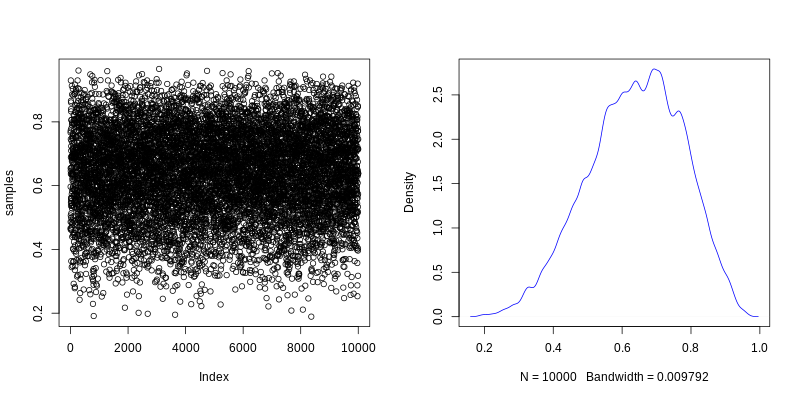

In [112]:
%%R -w 800 -h 400
par(mfrow=c(1,2))
plot(samples)
dens(samples,col='blue')

In [26]:
%%R 
sum(posterior[p_grid<0.5])

[1] 0.1718746


In [35]:
%%R 
sum(samples<0.5)/length(samples)

[1] 0.1763


In [37]:
%%R 
cond <- 0.5<samples & samples<0.75
sum(cond)/length(samples)

[1] 0.5981


In [43]:
%%R 
quantile(samples)

       0%       25%       50%       75%      100% 
0.1391391 0.5415415 0.6466466 0.7407407 0.9749750 


In [45]:
%%R 
quantile(samples,c(0.8,0.1,0.9))

      80%       10%       90% 
0.7607608 0.4474474 0.8128128 


      25%       75% 
0.7047047 0.9289289 


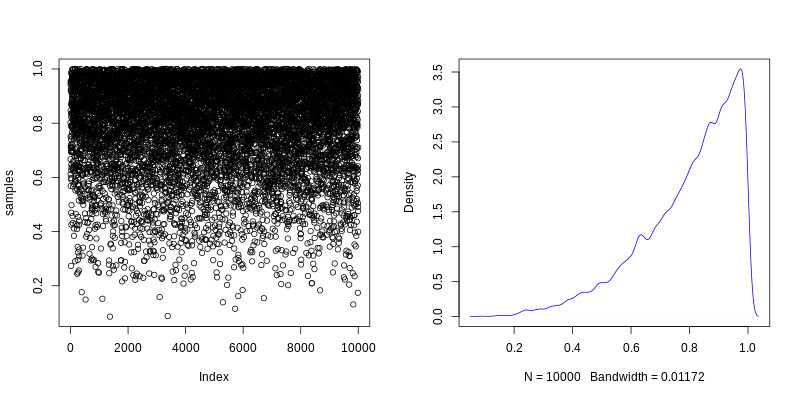

In [51]:
%%R -w 800 -h 400

p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- rep(1,1000)
likelihood <- dbinom( 3 , size=3 , prob=p_grid )
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample( p_grid , size=1e4 , replace=TRUE , prob=posterior )


par(mfrow=c(1,2))
plot(samples)
dens(samples,col='blue')

PI(samples, prob=0.5)

In [52]:
%%R 
quantile(samples,c(0.25,0.75))

      25%       75% 
0.7047047 0.9289289 


In [53]:
%%R 

HPDI(samples, prob=0.5)

     |0.5      0.5| 
0.8398398 1.0000000 


In [77]:
%%R 

c(
     MAP = p_grid[which.max(posterior)]    
    
    ,mean=mean(samples)
    ,median=median(samples)
    ,chainmode = chainmode(samples,adj=0.01)    
)


      MAP      mean    median chainmode 
1.0000000 0.7980452 0.8398398 0.9845821 


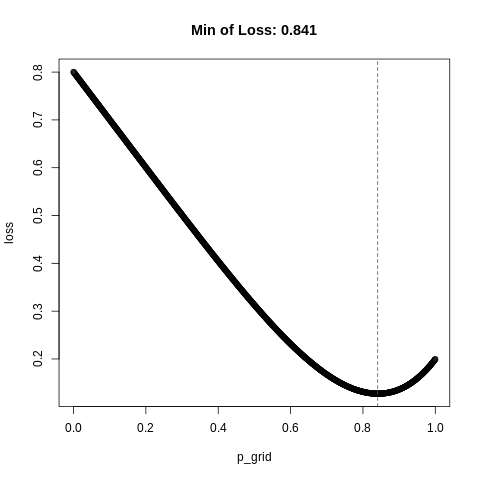

In [89]:
%%R 


loss <- sapply(p_grid, \(d)sum(posterior*abs(d-p_grid)))
p_star <- p_grid[which.min(loss)] 
plot(p_grid, loss, main=sprintf('Min of Loss: %.3f', p_star))
abline(v=p_star, col="red", lwd=1, lty=2)

# 3.3

In [103]:
%%R 
dbinom(0:2, size=2,prob=0.7)


[1] 0.09 0.42 0.49


In [105]:
%%R 
#dummy_w <- rbinom( 1e5 , size=2 , prob=0.7 ) 
dummy_w <- sample(0:2, size=1e5,prob=dbinom(0:2, size=2,prob=0.7), replace=TRUE)
table(dummy_w)/1e5

dummy_w
      0       1       2 
0.08982 0.41969 0.49049 


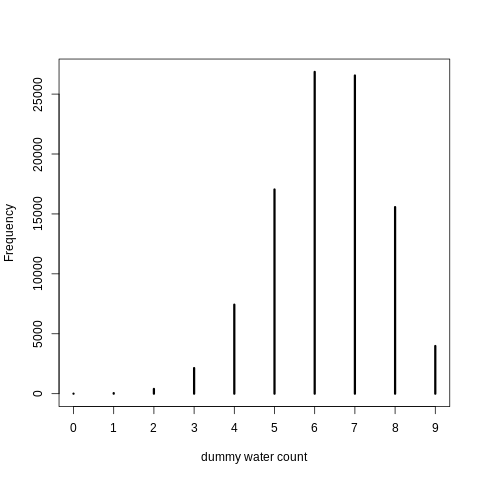

In [97]:
%%R 
dummy_w <- rbinom( 1e5 , size=9 , prob=0.7 )
simplehist( dummy_w , xlab="dummy water count" )

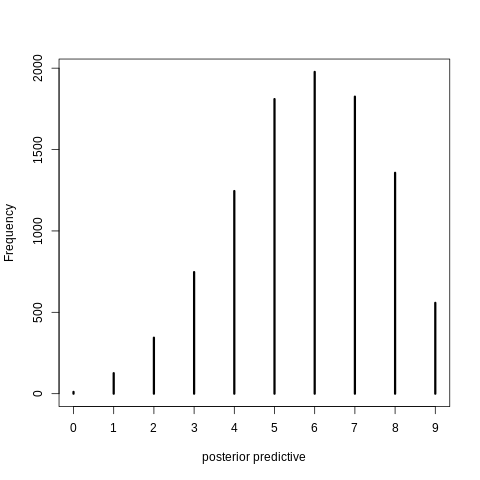

In [113]:
%%R 
simplehist(
    rbinom(1e4,size=9,prob=samples),
    xlab="posterior predictive" 
    
)